# Homework 2: Uncertainty and Vision
CS-229 Spring 2024

Submit **PDF** of completed IPython notebook on Canvas

**Due**: May 17, 2024 @ 11:59pm PDT

**Maximum points**: 15 (each HW is %15 of total grade)

<div style="margin-bottom: 15px; padding: 15px; color: #31708f; background-color: #d9edf7; border: 1px solid #bce8f1; border-radius: 5px;">
    
<b><font size=+2>Enter your information below:</font></b></br></br>

  <b>(full) Name</b>: quiet
  </br>
  <b>Student ID Number</b>:  :3
  </br></br>
    
<b>By submitting this notebook, I assert that the work below is my own work, completed for this course.  Except where explicitly cited, none of the portions of this notebook are duplicated from anyone else's work or my own previous work.</b>
</div>

In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models.segmentation import fcn_resnet50

from PIL import Image  # library for working with image files
import matplotlib.pyplot as plt


torch.manual_seed(100)  # for reproducibility

# If using colab, I recommend you use a cuda instance for this
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device  # For macs
print(f"Using {device}")

def viz_images(image, labels, pred_labels=None, n_class=20):
    """Visualize an image and the segmentation labels,
    and optionally the predicted labels."""
    image = image.detach().cpu().numpy().transpose(1, 2, 0)  # matplot wants channel LAST
    labels = labels.detach().cpu().numpy().squeeze()

    # Apply color map to the pixel classes
    cmap = plt.cm.get_cmap('tab20', n_class + 1)  # tab20 is a colormap with 20 distinct colors
    labels = cmap(labels)  # Map classes to distinct colors
    if pred_labels is not None:
        pred_labels = pred_labels.detach().cpu().numpy().squeeze()
        pred_labels = cmap(pred_labels)

    # Visualize the image and mask
    n_images = 3 if pred_labels is not None else 2
    fig, ax = plt.subplots(1, n_images, figsize=(5 * n_images, 5))
    ax[0].imshow((1+image)/2)  # scale pixel range from [-1,1] to [0,1]
    ax[0].axis('off')
    ax[0].set_title('Image')
    ax[1].imshow(labels)
    ax[1].axis('off')
    ax[1].set_title('Pixel labels')
    if pred_labels is not None:
        ax[2].imshow(pred_labels)
        ax[2].axis('off')
        ax[2].set_title('Predicted labels')
    plt.show()

Using cuda


## Get the data and visualize [3 points]

We're downloading a classic (smaller, older) segmentation dataset.

In [ ]:
class ToIntTensor(transforms.ToTensor):
    """A custom transform that replaces "ToTensor". ToTensor always converts to a
    a float in range [0,1]. This one converts to an integer, which can represent
    our class labels per pixel in an image segmentation problem"""
    def __call__(self, pic):
        tensor = super().__call__(pic)
        tensor = (tensor * 255).to(torch.int64)
        return tensor


# TODO: 3 points. Define image transforms for both the input image AND the "label" image.
# Remember, the labels are one category (integer) per pixel. So, while the image_transform
# normalizes the values to the range [-1, 1], you shouldn't
# do that with the labels, which have to be integers.
# I provided a "ToIntTensor" transform to use for the label transform,
# instead of transforms.ToTensor which turns images to floats.
# Let's resize and center crop images to be all the same size, and
# we should transform the label and image in the same way when changing size.
# The size of images will drastically impact memory usage -
# Output an image with height by width of 128 x 128

# Define the transformations for the input images
image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.CenterCrop((128, 128)),  # Center crop to 128x128
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to [-1, 1]
])

# Define the transformations for the label images
label_transforms = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.NEAREST),  # Resize to 128x128 using nearest neighbor to avoid changing label values
    transforms.CenterCrop((128, 128)),  # Center crop to 128x128
    ToIntTensor()  # Convert to integer tensor
])

data_dir = '.'
# Transforms defined above are applied by this data downloader
train_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='train', download=True,
                                         transform=image_transforms, target_transform=label_transforms)
val_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='val', download=True,
                                       transform=image_transforms, target_transform=label_transforms)
n_class = 21  # number of classes for each pixel

# Create data loaders for the datasets - necessary for efficient training
train_batch_size = 64  # Usually increase to fill GPU memory
val_batch_size = 128  # Usually can be bigger, because we don't do backprop
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)

for images, masks in train_dl:
    images = images.to(device)
    masks = masks.to(device).squeeze(1)  # Ensure masks are correctly shaped
    print(images.shape, masks.shape)  # Debug: check shapes

for images, masks in val_dl:
    images = images.to(device)
    masks = masks.to(device).squeeze(1)  # Ensure masks are correctly shaped
    print(images.shape, masks.shape)  # Debug: check shapes

Using downloaded and verified file: ./VOCtrainval_06-Nov-2007.tar
Extracting ./VOCtrainval_06-Nov-2007.tar to .
Using downloaded and verified file: ./VOCtrainval_06-Nov-2007.tar
Extracting ./VOCtrainval_06-Nov-2007.tar to .
torch.Size([64, 3, 128, 128]) torch.Size([64, 128, 128])
torch.Size([64, 3, 128, 128]) torch.Size([64, 128, 128])
torch.Size([64, 3, 128, 128]) torch.Size([64, 128, 128])
torch.Size([17, 3, 128, 128]) torch.Size([17, 128, 128])
torch.Size([128, 3, 128, 128]) torch.Size([128, 128, 128])
torch.Size([85, 3, 128, 128]) torch.Size([85, 128, 128])


<ipython-input-1-6aed8f95d73e>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', n_class + 1)  # tab20 is a colormap with 20 distinct colors


Shape of x torch.Size([64, 3, 128, 128]) Shape of y torch.Size([64, 1, 128, 128])
Example y values appearing in first batch:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 255}


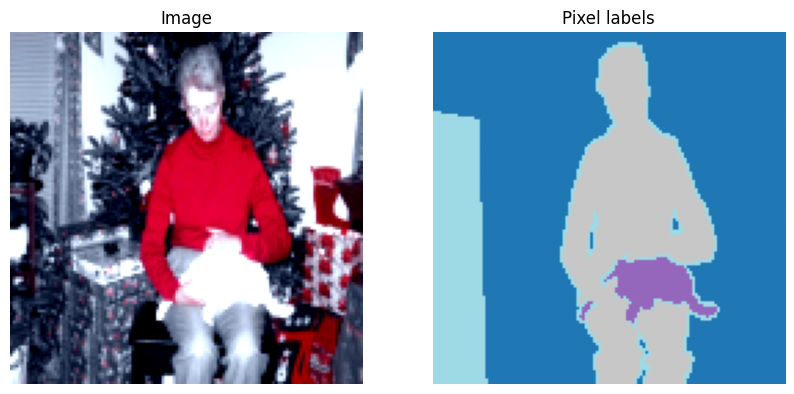

In [ ]:
# Inspect the data
for batch in train_dl:
    x, y = batch
    break

print('Shape of x', x.shape, "Shape of y", y.shape)
# x has 3 channels for RGB, y has one channel for class
# So we have (batch, channels, height, width)
print('Example y values appearing in first batch: ', set(y.flatten().tolist()))
# Note that "255" appears - it represents masked pixels that are not meant to be predicted
# Class 0 = background
# class 1-20: person, bird, cat, cow, dog, horse, sheep, aeroplane, bicycle, boat, bus, car, motorbike, train, bottle, chair, dining table, potted plant, sofa, tv/monitor

viz_images(x[0], y[0])

## Load the model and inspect [1 point]
We'll use a fully convolutional network.

In [ ]:
model = fcn_resnet50(n_class=n_class).to(device)
# Try to inspect the architecture for fun, though it's not easy to read

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 156MB/s]


In [ ]:
# TODO: 1 point. Add test statements to test model properties and check that they pass
def test_fcn_property(model, device):
    """Construct some randomly sized inputs, and test that the
    outputs match in an expected way."""
    channels = 3  # RGB channels
    for batch_size in [1, 5]:
        for height in [17, 64, 128]:
            for width in [64, 128]:
                x = torch.randn((batch_size, channels, height, width), device=device)
                print("Test input shape", x.shape)
                # TODO: Get model output for this random input
                # add assert tests for what output shape should be
                model.eval()  # Set the model to evaluation mode
                with torch.no_grad():  # No need to track gradients
                    out = model(x)['out']  # Assuming 'out' is the key for the output in the model's returned dictionary
                # Add assert tests for what output shape should be
                assert out.shape[0] == batch_size, f"Expected batch size {batch_size}, but got {out.shape[0]}"
                assert out.shape[1] == n_class, f"Expected number of classes {n_class}, but got {out.shape[1]}"
                assert out.shape[2] == height, f"Expected height {height}, but got {out.shape[2]}"
                assert out.shape[3] == width, f"Expected width {width}, but got {out.shape[3]}"


    print("Passed all tests")


test_fcn_property(model, device)

Test input shape torch.Size([1, 3, 17, 64])
Test input shape torch.Size([1, 3, 17, 128])
Test input shape torch.Size([1, 3, 64, 64])
Test input shape torch.Size([1, 3, 64, 128])
Test input shape torch.Size([1, 3, 128, 64])
Test input shape torch.Size([1, 3, 128, 128])
Test input shape torch.Size([5, 3, 17, 64])
Test input shape torch.Size([5, 3, 17, 128])
Test input shape torch.Size([5, 3, 64, 64])
Test input shape torch.Size([5, 3, 64, 128])
Test input shape torch.Size([5, 3, 128, 64])
Test input shape torch.Size([5, 3, 128, 128])
Passed all tests


## Train the segmentation model [5 points]

Let's implement some best practices - tracking the train and validation loss for plotting. (There are libraries like tensorboard or wandb that do this, but we'll do it by hand.)

In [ ]:
# Optimization hyper-parameters
epochs = 50
learning_rate = 0.01
momentum = 0.9  # We'll talk about this soon!
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)  # SGD optimizer

# Loss
# We'll use the cross entropy loss. There's a nice feature that it
# allows you to "ignore_index". In this case index 255 is the mask to ignore
# Also, we can add weights to the classes. Here, we want to downweight the "background" class
weight = torch.tensor([0.1] + [1. for i in range(20)], device=device)  # downweight class 0 - background class
criterion = nn.CrossEntropyLoss(weight=weight, ignore_index=255)

# Training loop
train_losses, val_losses = [], []  # Track the train/val loss
for epoch in range(epochs):

    model.train()  # Set model to training mode
    train_loss = 0.0  # Track average train_loss per epoch here
    for inputs, labels in train_dl:  # Assuming the dataloader returns tuples of (inputs, labels)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = model(inputs)['out']  # Forward pass: compute predicted outputs

        # Make sure labels are the correct shape
        labels = labels.squeeze(1)  # Squeeze the singleton dimension if present

        loss = criterion(outputs, labels)  # Calculate batch loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step

        train_loss += loss.item() * inputs.size(0)  # Accumulate scaled loss

    train_loss /= len(train_dl.dataset)  # Calculate average loss

    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0  # Correct pixels count
    total = 0  # Total pixels count
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for inputs, labels in val_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)['out']

            # Make sure labels are the correct shape
            labels = labels.squeeze(1)  # Squeeze the singleton dimension if present

            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            preds = outputs.argmax(dim=1)  # Get the index of the max log-probability
            valid = (labels != 255)  # Ignore index mask
            correct += (preds == labels).masked_select(valid).sum().item()
            total += valid.sum().item()

    val_loss /= len(val_dl.dataset)
    accuracy = correct / total  # Calculate accuracy

    # Print the loss, and store for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if epoch % 5 == 0:
        print('Epoch %d: Train loss: %.3f | Val loss: %.3f | Acc: %.3f' % (epoch+1, train_loss, val_loss, accuracy))


Epoch 1: Train loss: 2.662 | Val loss: 2.326 | Acc: 0.139
Epoch 6: Train loss: 0.490 | Val loss: 1.275 | Acc: 0.698
Epoch 11: Train loss: 0.320 | Val loss: 1.219 | Acc: 0.780
Epoch 16: Train loss: 0.228 | Val loss: 1.315 | Acc: 0.801
Epoch 21: Train loss: 0.190 | Val loss: 1.363 | Acc: 0.811
Epoch 26: Train loss: 0.171 | Val loss: 1.457 | Acc: 0.821
Epoch 31: Train loss: 0.147 | Val loss: 1.516 | Acc: 0.819
Epoch 36: Train loss: 0.140 | Val loss: 1.449 | Acc: 0.812
Epoch 41: Train loss: 0.127 | Val loss: 1.459 | Acc: 0.816
Epoch 46: Train loss: 0.117 | Val loss: 1.417 | Acc: 0.814


## Post training visualization and analysis [3 points]

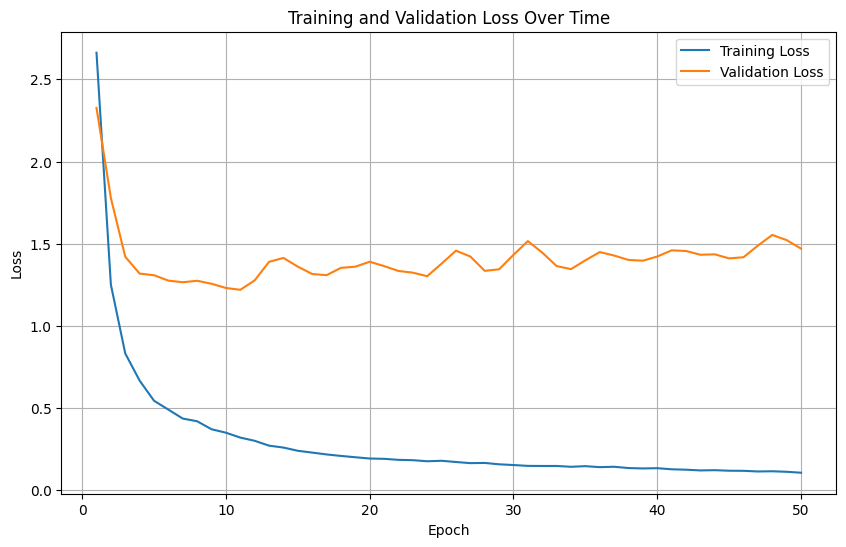

In [ ]:
# TODO [2 points]: Plot the train and validation loss over time, on the same plot
# Add a legend with labels for each curve, label axes
import matplotlib.pyplot as plt

# Assuming train_losses and val_losses are lists containing the loss values for each epoch
epochs_range = range(1, epochs + 1)  # Create a range for the x-axis

plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(epochs_range, train_losses, label='Training Loss')  # Plot training loss
plt.plot(epochs_range, val_losses, label='Validation Loss')  # Plot validation loss

plt.title('Training and Validation Loss Over Time')  # Add a title to the plot
plt.xlabel('Epoch')  # Label the x-axis
plt.ylabel('Loss')  # Label the y-axis
plt.legend()  # Add a legend to identify the lines
plt.grid(True)  # Add a grid for better readability
plt.show()  # Display the plot


<ipython-input-1-6aed8f95d73e>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', n_class + 1)  # tab20 is a colormap with 20 distinct colors


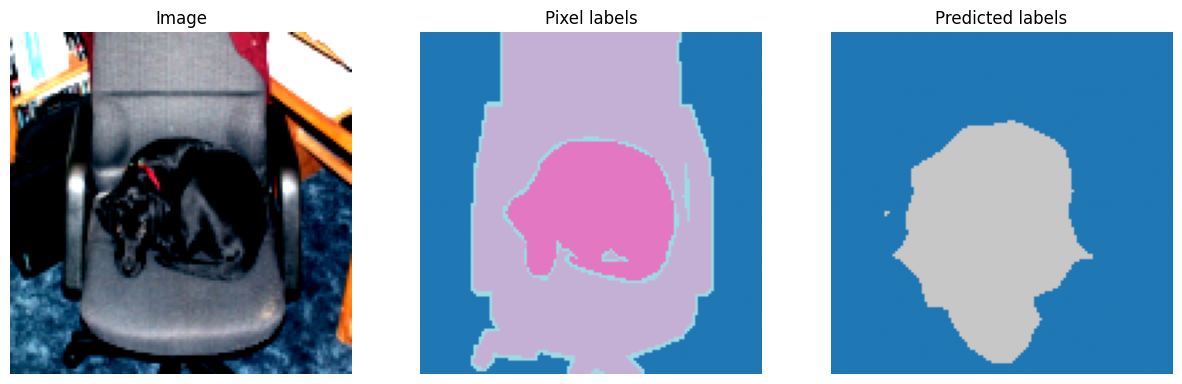

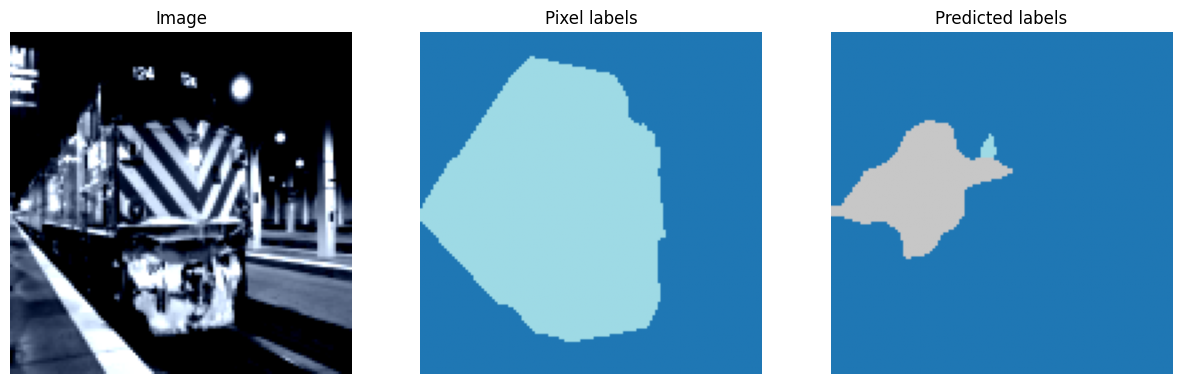

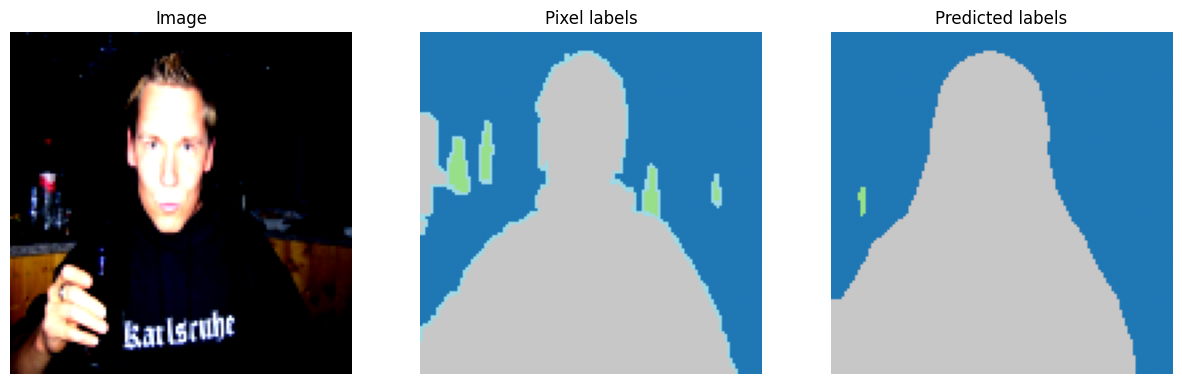

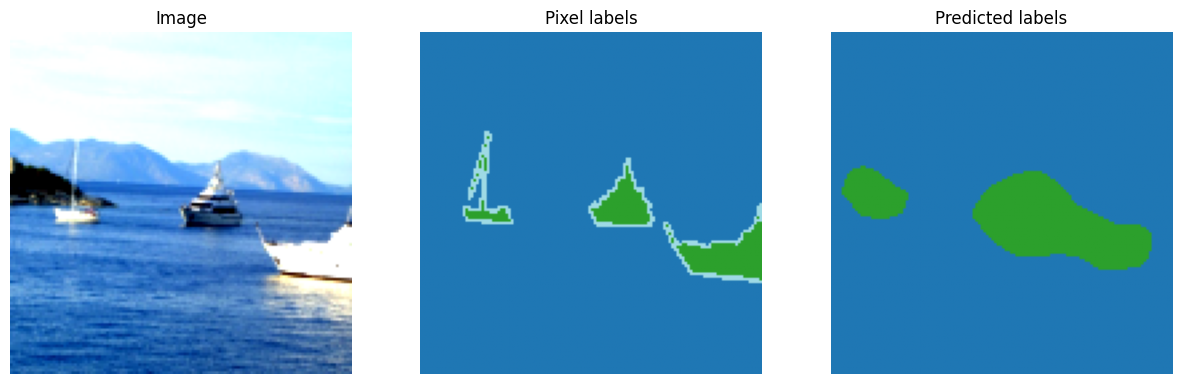

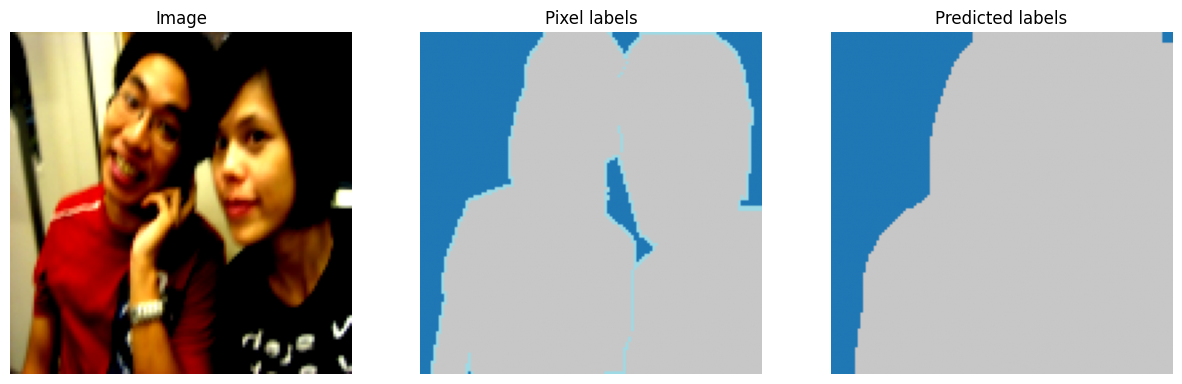

In [ ]:
# TODO [1 point]: Print out an example image, true segmentation, and predicted segmentation
# You shouldn't have to modify this - but we will look for whether you
# manage to get vaguely reasonable blobs like I did
model.eval()  # Set the model to evaluation mode
for batch in val_dl:
    with torch.no_grad():  # Turn off gradients to speed up this part
        images, true_labels = batch  # Assuming batch returns a tuple of (images, labels)
        images, true_labels = images.to(device), true_labels.to(device)
        outputs = model(images)['out']  # Generate predictions
        pred_labels = outputs.argmax(dim=1).to('cpu')  # Get the predicted class labels
    break  # Break after the first batch

selected_indices = [1, 3, 4, 5, 6]  # Select a few sample indices to visualize
for i in selected_indices:
    viz_images(images[i].to('cpu'), true_labels[i].to('cpu'), pred_labels[i])


## Confidence calibration [3 points]

Here, you'll look at how well calibrated your model is, and get the expected calibration error.

In [ ]:
# Feel free to use the outputs of my code for the confidence calibration plot and ECE
# Here I run the model on all points in the validation set.
# I collect predictions on all pixels, excluding masks, and flatten them.

import numpy as np
def calibration_curve(model, val_dl, device, bins=10):
    """Run model on the dataloader. For each range of confidence values,
    calculate the accuracy for predictions with confidence in that range.
    """
    model.eval()
    with torch.no_grad():
        all_acc = []  # accuracy for each pixel prediction
        all_conf = []  # confidence for each pixel prediction
        for i, (inputs, labels) in enumerate(val_dl):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)['out']
            labels = labels.squeeze(1).flatten(start_dim=1)  # batch, h, w  - integer values 0..20 or 255 for mask
            predicted_label = outputs.argmax(axis=1).flatten(start_dim=1)  # batch, h, w, integer 0...20
            probs = outputs.softmax(axis=1)  # batch, n_class, h, w
            confidence = probs.max(axis=1).values.flatten(start_dim=1)  # Confidence in predicted label
            accuracy = (predicted_label == labels)
            accuracy_filter = accuracy[labels < 255]  # remove masks
            confidence_filter = confidence[labels < 255]  # remove masks
            all_acc.append(accuracy_filter)
            all_conf.append(confidence_filter)

    all_acc = torch.cat(all_acc).cpu().numpy()  # accuracy to predict pixel class across all pixels and images, excluding masks
    all_conf = torch.cat(all_conf).cpu().numpy()  # confidence of prediction for each pixel and image, excluding masks

    # Get the average confidence and accuracy for points within different confidence ranges
    bin_boundaries = np.linspace(0, 1, bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    bin_centers = 0.5*(bin_lowers+bin_uppers)
    bin_acc = np.zeros(bins)  # Store accuracy within each bin
    bin_conf = np.zeros(bins)  # Store confidence within each bin
    bin_frac = np.zeros(bins)  # Store the fraction of data in included in each bin
    for i in range(bins):
        in_bin = np.logical_and(all_conf >= bin_lowers[i], all_conf < bin_uppers[i])  # pick all points with confidence in bin
        bin_frac[i] = np.sum(in_bin) / len(all_conf)  # fraction of points in bin
        if bin_frac[i] > 0.:
            bin_acc[i] = all_acc[in_bin].mean()  # average accuracy in this bin
            bin_conf[i] = all_conf[in_bin].mean()  # average confidence in this bin
        else:
            bin_acc[i], bin_conf[i] = 0, 0  # If no points are in this bin, they don't contribute to ECE anyway

    # bin_centers - center of confidence range for each bin
    # bin_acc - the accuracy for all predictions that had confidence in this bin
    # bin_conf - the average confidence in this bin
    # bin_frac - fraction of points appearing in each bin
    return bin_frac, bin_centers, bin_acc, bin_conf


bin_frac, bin_centers, bin_acc, bin_conf = calibration_curve(model, val_dl, device)

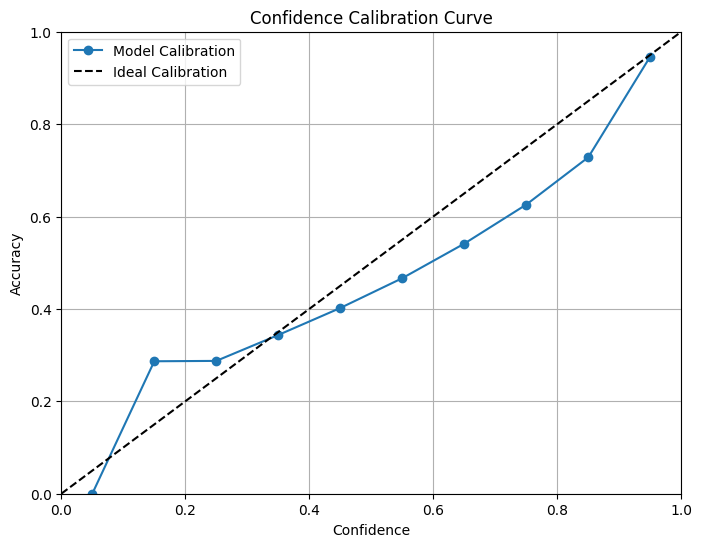

In [ ]:
# TODO: 2 points
# Use the computed values to plot the confidence calibration curve

# Plot confidence calibration curve
# Also show the ideal curve for comparison, and label curves and axes

import matplotlib.pyplot as plt

def plot_confidence_calibration(bin_centers, bin_acc, bin_conf):
    plt.figure(figsize=(8, 6))  # Set the size of the figure
    plt.plot(bin_centers, bin_acc, 'o-', label='Model Calibration')  # Plot the calibration curve for the model
    plt.plot([0, 1], [0, 1], 'k--', label='Ideal Calibration')  # Plot the ideal calibration line
    plt.xlabel('Confidence')  # Label the x-axis
    plt.ylabel('Accuracy')  # Label the y-axis
    plt.title('Confidence Calibration Curve')  # Give the plot a title
    plt.legend()  # Add a legend to explain the lines
    plt.grid(True)  # Add a grid for better readability
    plt.ylim([0, 1])  # Set the limits of the y-axis to ensure the range is from 0 to 1
    plt.xlim([0, 1])  # Set the limits of the x-axis to ensure the range is from 0 to 1
    plt.show()  # Display the plot

plot_confidence_calibration(bin_centers, bin_acc, bin_conf)


In [ ]:
# TODO: 1 point
# Print the expected calibration error
def calculate_ece(bin_acc, bin_conf, bin_frac):
    """Calculate the Expected Calibration Error (ECE)"""
    ece = np.sum(np.abs(bin_acc - bin_conf) * bin_frac)  # Weighted sum of absolute differences
    return ece

ece = calculate_ece(bin_acc, bin_conf, bin_frac)
print("Expected Calibration Error (ECE): {:.4f}".format(ece))


Expected Calibration Error (ECE): 0.0558


### Extra credit
For extra credit, you can try some modification to the learning to see if it improves the ECE. Examples of things to try are below, just append the result in this notebook. (And give a text summary describing what method you are trying, and how the ECE changed.)  

We'll give 1 point of extra credit for this (only 1 point though, even if you try multiple methods).

- Explore transfer learning strategies

- Simple regularizers / hyper-parameters like: L2 regularization / weight decay, dropout, early stopping, learning rate schedulers…

- Data augmentation strategies: scaling, flips, color change, different image shapes, etc.

- Monte Carlo dropout (average test time predictions with dropout to estimate uncertainty)

- Use an ensemble of models, with simple averaging of the output probabilities.

- Model size effects